# Running Parameterized FCNNs

Now that we have taken time to explore and understand FCNNs, we will now run a parameterization of our own.

In [1]:
# Import required modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import json
import fsspec
from pyqg_parameterization_benchmarks.neural_networks import FCNNParameterization, FullyCNN

%matplotlib inline

Below we are loading a sample dataset, as training data for our parameterization, of a high-resolution simulation in the eddy configuration started from random noise and run over a span of 10 simulation years that has been coarsened using Operator 2 (a spectral truncation + softer Gaussian filter). 

In [2]:
training_ds = xr.open_zarr('/home/jovyan/datasets/eddy/op2/ds1').load()
training_ds

<xarray.Dataset>
Dimensions:            (time: 87, lev: 2, y: 64, x: 64, l: 64, k: 33, lev_mid: 1)
Coordinates:
  * k                  (k) float64 0.0 6.283e-06 ... 0.0001948 0.0002011
  * l                  (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev                (lev) int64 1 2
  * lev_mid            (lev_mid) float64 1.5
  * time               (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x                  (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Data variables: (12/23)
    Qy                 (time, lev) float64 1.039e-10 -7.222e-12 ... -7.222e-12
    Ubg                (time, lev) float64 0.025 0.0 0.025 0.0 ... 0.0 0.025 0.0
    dqdt               (time, lev, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dqhdt              (time, lev, l, k) complex128 0j 0j 0j 0j ... 0j 0j 0j 0j
    p                  (time, lev, y, x) float64 -39.07 -62.7 ... -77.82 33.89
    ph                 (time, lev, l, k) complex128 0j ... (11.85916120645425...
    ...                 ...
    v                  (time, lev, y, x) float64 -0.001415 ... 0.006776
    v_subgrid_forcing  (time, lev, y, x) float64 2.498e-13 ... 8.655e-11
    vfull              (time, lev, y, x) float64 -0.001415 ... 0.006776
    vh                 (time, lev, l, k) complex128 0j ... 0.007440851489267999j
    vq_subgrid_flux    (time, lev, y, x) float64 -2.542e-12 ... 1.934e-10
    vv_subgrid_flux    (time, lev, y, x) float64 3.388e-07 ... 1.838e-06
Attributes: (12/23)
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  315360000.0
    pyqg:tc:         0
    pyqg:tmax:       1576800000.0
    pyqg:twrite:     1000.0
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

The parameterization we are using for this example is an FCNN trained on the values of PV and velocity to estimate PV subgrid forcing computed with Operator 2.

In [ ]:
param = FCNNParameterization.train_on(training_ds, '/home/jovyan/models/fcnn_qu_to_Sq2', 
                                      inputs=['q', 'u', 'v'], 
                                      targets = ['q_subgrid_forcing']) 

Now that we have a trained parameterization we can begin testing it. We call `test_offline()` on the parameterization instance to begin evaluating the parameterization on an offline dataset.

In [5]:
# Helpers methods to help visualize offline metrics/performance
def imshow(arr):
    plt.imshow(arr, vmin=0, vmax=1, cmap='inferno')
    mean = arr.mean().data
    plt.text(32, 32, f"{mean:.2f}", color=('white' if mean<0.75 else 'black'),
             fontweight='bold', ha='center', va='center', fontsize=16)
    plt.xticks([]); plt.yticks([])
    
def colorbar(label):
    plt.colorbar().set_label(label, fontsize=16,rotation=0,ha='left',va='center')

Upon calling `test_offline()`, an `xarray.Dataset` object describing the predictions made by the parameterization is returned. Included within this dataset are a number of computed metrics.

In [12]:
test_ds = xr.open_zarr('/home/jovyan/datasets/eddy/op2/ds2').load()
preds1 = param.test_offline(test_ds)
preds1

<xarray.Dataset>
Dimensions:                                 (time: 87, lev: 2, y: 64, x: 64)
Coordinates:
  * lev                                     (lev) int64 1 2
  * time                                    (time) float64 0.0 0.0 ... 0.0 0.0
  * x                                       (x) float64 7.812e+03 ... 9.922e+05
  * y                                       (y) float64 7.812e+03 ... 9.922e+05
Data variables: (12/14)
    q_subgrid_forcing                       (time, lev, y, x) float64 5.552e-...
    q_subgrid_forcing_predictions           (time, lev, y, x) float64 -6.531e...
    q_subgrid_forcing_spatial_mse           (lev, y, x) float64 1.242e-23 ......
    q_subgrid_forcing_temporal_mse          (time, lev) float64 2.242e-27 ......
    q_subgrid_forcing_mse                   (lev) float64 9.821e-24 1.093e-27
    q_subgrid_forcing_spatial_skill         (lev, y, x) float64 0.0204 ... 0....
    ...                                      ...
    q_subgrid_forcing_spatial_correlation   (lev, y, x) float64 0.1719 ... 0....
    q_subgrid_forcing_temporal_correlation  (time, lev) float64 0.004937 ... ...
    q_subgrid_forcing_correlation           (lev) float64 0.5452 0.8939
    correlation                             (lev) float64 0.5452 0.8939
    mse                                     (lev) float64 9.821e-24 1.093e-27
    skill                                   (lev) float64 0.2967 0.7989
Attributes: (12/23)
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  315360000.0
    pyqg:tc:         0
    pyqg:tmax:       1576800000.0
    pyqg:twrite:     1000.0
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

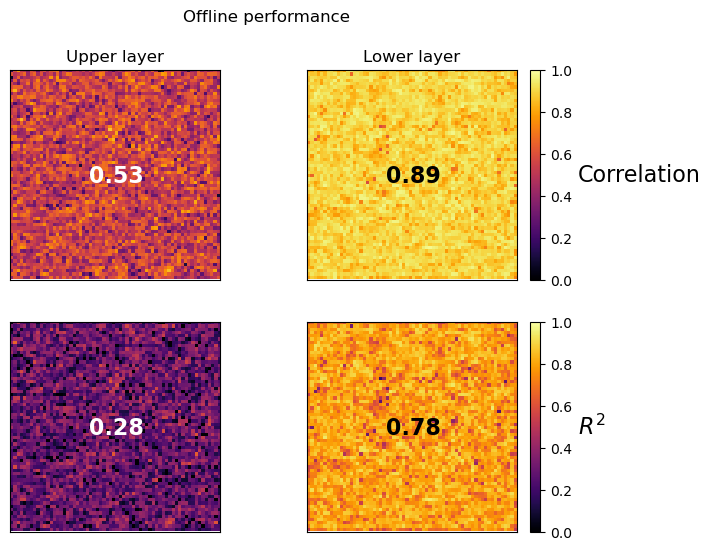

In [15]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds1.q_subgrid_forcing_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds1.q_subgrid_forcing_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

We can improve these offline metrics by training our FCNN on more datasets. Below, we feed another dataset into each model, extract the input and target features from the dataset, and standardize by calling `fit()` which also then initiates a training session on the inputs and targets.

In [ ]:
training_ds2 = xr.open_zarr('/home/jovyan/datasets/eddy/op2/ds3').load()
for m in param.models:
    new_inputs = m.extract_inputs(training_ds2)
    new_targets = m.extract_targets(training_ds2)
    m.fit(new_inputs, new_targets, rescale=True)

We then run predictions again with the same, initial test dataset on the parameterization after its been trained on another dataset.

In [4]:
preds2 = param.test_offline(test_ds)
preds2

<xarray.Dataset>
Dimensions:                                 (time: 87, lev: 2, y: 64, x: 64)
Coordinates:
  * lev                                     (lev) int64 1 2
  * time                                    (time) float64 0.0 0.0 ... 0.0 0.0
  * x                                       (x) float64 7.812e+03 ... 9.922e+05
  * y                                       (y) float64 7.812e+03 ... 9.922e+05
Data variables: (12/14)
    q_subgrid_forcing                       (time, lev, y, x) float64 5.552e-...
    q_subgrid_forcing_predictions           (time, lev, y, x) float64 -6.373e...
    q_subgrid_forcing_spatial_mse           (lev, y, x) float64 7.614e-24 ......
    q_subgrid_forcing_temporal_mse          (time, lev) float64 3.353e-27 ......
    q_subgrid_forcing_mse                   (lev) float64 4.449e-24 8.302e-28
    q_subgrid_forcing_spatial_skill         (lev, y, x) float64 0.3996 ... 0.536
    ...                                      ...
    q_subgrid_forcing_spatial_correlation   (lev, y, x) float64 0.7024 ... 0....
    q_subgrid_forcing_temporal_correlation  (time, lev) float64 -0.006284 ......
    q_subgrid_forcing_correlation           (lev) float64 0.8257 0.9204
    correlation                             (lev) float64 0.8257 0.9204
    mse                                     (lev) float64 4.449e-24 8.302e-28
    skill                                   (lev) float64 0.6814 0.8472
Attributes: (12/23)
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  315360000.0
    pyqg:tc:         0
    pyqg:tmax:       1576800000.0
    pyqg:twrite:     1000.0
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

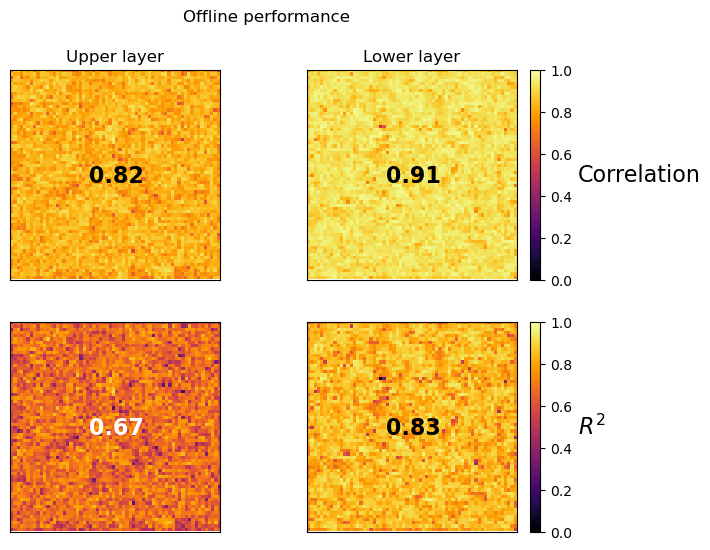

In [6]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds2.q_subgrid_forcing_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds2.q_subgrid_forcing_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

As shown, our computed metrics improved with additional training. We then save our newly trained models to the model directory path for our parameterization in order to keep the updated trained state of the models.

In [7]:
param.models[0].save('/home/jovyan/models/fcnn_qu_to_Sq2/models/0')
param.models[1].save('/home/jovyan/models/fcnn_qu_to_Sq2/models/1')

We can then reload the FCNN parameterization in future use cases by instantiating a new `FCNNParameterization` instance and passing in the directory path at which the parameterization is saved, as follows:

In [2]:
param = FCNNParameterization('/home/jovyan/models/fcnn_qu_to_Sq2')